## Evaluating Time Series

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
register_matplotlib_converters()

### Ice Cream Production Data

In [2]:
s_icecream = pd.read_csv('Data/ice_cream.csv', parse_dates=[0], index_col=0, 
                          date_format='%Y-%m-%d').squeeze()

In [3]:
s_icecream.rename('Production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: Production, Length: 577, dtype: float64

In [4]:
s_icecream.index.rename('Date', inplace=True)

In [5]:
# Infer frequency of data => beginning of month
s_icecream = s_icecream.asfreq(pd.infer_freq(s_icecream.index))

In [6]:
# Just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
s_icecream = s_icecream[start_date:]

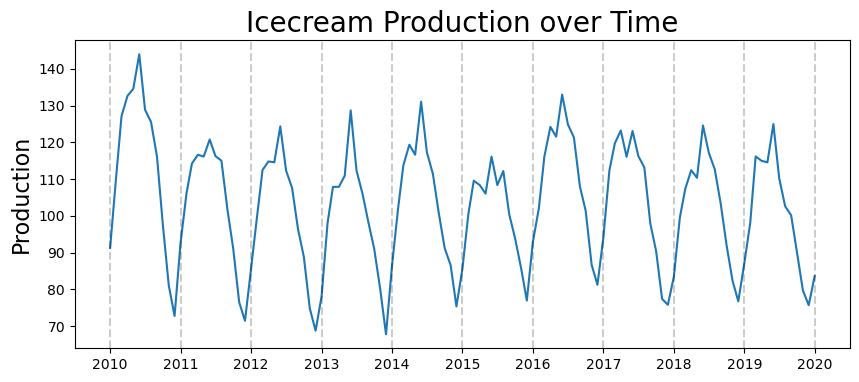

In [7]:
plt.figure(figsize=(10,4))
plt.plot(s_icecream)
plt.title('Icecream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

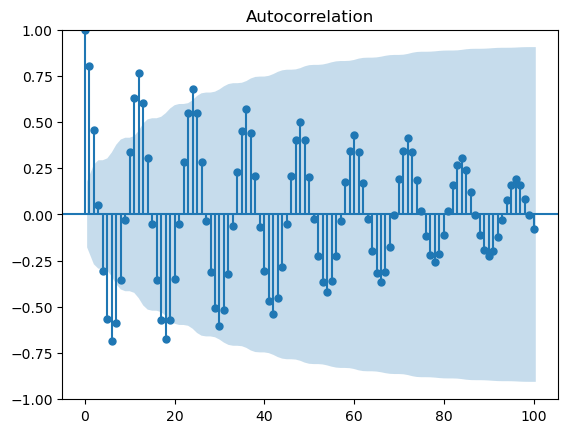

In [8]:
acf_plot = plot_acf(s_icecream, lags=100)

Decaying ACF => Autoregressive Process

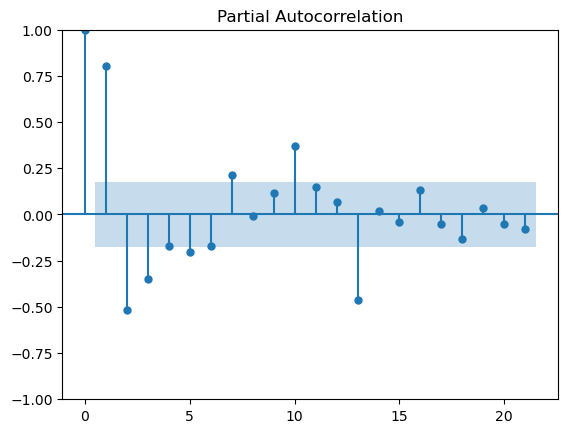

In [9]:
pacf_plot = plot_pacf(s_icecream)

#### AR Modeling

Based on the PACF, we should start with an AR-3 Model: $X_t = \beta_0+\beta_1X_{t-1}+\beta_2X_{t-2}+\beta_3X_{t-3}+\varepsilon_t$

In [10]:
# Split training and test set according to 70%/30% rule
train_end = datetime(2016, 12, 1)
test_end = datetime(2019, 12, 1)

s_train = s_icecream[:train_end]
s_test = s_icecream[train_end + timedelta(days=1):test_end]

In [11]:
# Create the model
ar_model = ARIMA(s_train, order=(3,0,0)) # 3 lags, no differences and moving averages

In [12]:
# Fit the model
start = time()
ar_fit = ar_model.fit()
end = time()
print('Model fitting time:', end - start, 's')

Model fitting time: 0.0378720760345459 s


In [13]:
# Summary of the model
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Wed, 11 Sep 2024   AIC                            598.015
Time:                        14:46:48   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

We can see that the second lag is not statistically significantly different from zero.

In [14]:
# Get predictions and residuals
preds = ar_fit.predict(start=s_test.index[0], end=s_test.index[-1])
residuals = s_test - preds

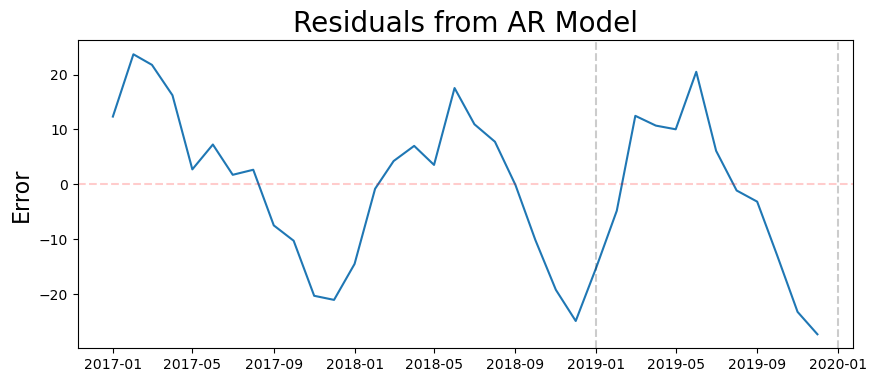

In [15]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=.2)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

There's a clear pattern in the residuals, meaning that there's some dynamic in the data that we fail to capture.

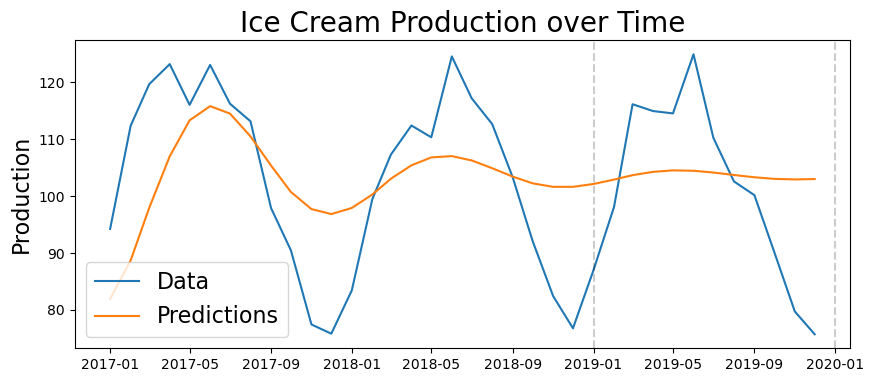

In [16]:
plt.figure(figsize=(10,4))
plt.plot(s_test)
plt.plot(preds)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

After the first year, the predictions even out. In time-series analysis, predictions which are closer in time to the training data are much better than for future observations.

In [18]:
# On average, what percent away are we from our actual target?
print('Mean Absolute Percent Error:', 100 * round(np.mean(abs(residuals/s_test)), 4))

Mean Absolute Percent Error: 12.11


In [19]:
# On average, how many units away are we from our actual target?
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals ** 2)))

Root Mean Squared Error: 13.89010233397718


### Rolling Forecast Origin

For time series, the 70-30 split is a bad idea since predictions for further time periods are highly inaccurate. Moreover, predicting time periods far in the future are usually not of interest and new data is quickly available. Hence, time-series analysis usually employ a rolling forecast origin. The idea is straightforward:

#### Idea: Predict one month in advance each time
- **Train on months** $1,2,\ldots,k-3\rightarrow$ **predict month** $k-2$
- **Train on months** $1,2,\ldots,k-3,k-2\rightarrow$ **predict month** $k-1$
- **Train on months** $1,2,\ldots,k-3,k-2,k-1\rightarrow$ **predict month** $k$

...

#### Average all predictions

In [21]:
# Create model
preds_rolling = pd.Series()
for end_date in s_test.index:
    s_train = s_icecream[:end_date - timedelta(days=1)]
    ar_model = ARIMA(s_train, order=(3,0,0))
    ar_fit = ar_model.fit()
    pred = ar_fit.predict(end_date)
    preds_rolling.loc[end_date] = pred.loc[end_date]

In [29]:
s_test.index

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [22]:
residuals_rolling = s_test - preds_rolling

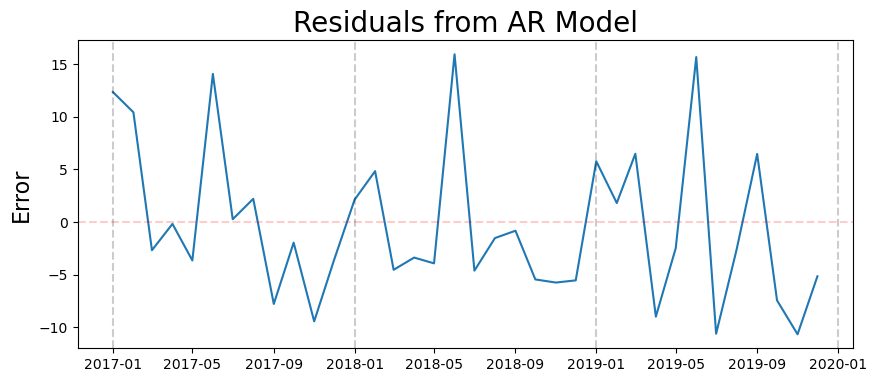

In [23]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=.2)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

Although there is some volatility, there is not a systematic pattern in the residuals like in the 70-30 split case.

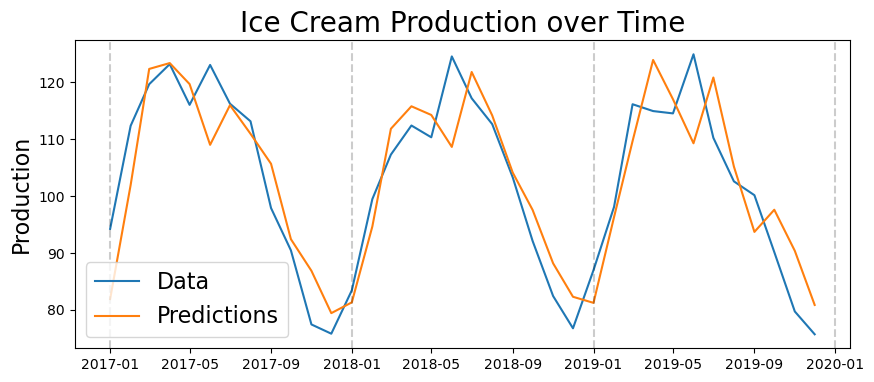

In [26]:
plt.figure(figsize=(10,4))
plt.plot(s_test)
plt.plot(preds_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

In [27]:
print('Mean Absolute Percent Error:', 100 * round(np.mean(abs(residuals_rolling/s_test)), 4))

Mean Absolute Percent Error: 5.82


In [28]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling ** 2)))

Root Mean Squared Error: 7.19651364026364
